# Урок 4. Классификация текста. Анализ тональности текста.

### Тональность текста
В блокноте text_classification.ipynb разобрали анализ тональности используя полносвязанную сеть сделать на тех же данных
1. tf-idf/count vectorizer + логистическую регрессию
2. Обучить вашу архитектуре сети возможно туже что и была на занятии проверить
- взять предобученный эмбединг(к примеру word2vec) и загрузить в слой Embedding
- взять слой Embedding без предобученных весов

Сравнить все подходы в том числе и полносвязанную сеть что лучше отработало

### Классификация текста
В качестве заготовки для задания прогоним часть 2ого домашнего задания. Нам необходимо получить разреженные матрицы, используя CountVectorizer, TfidfVectorizer для 'tweet_stemmed' и 'tweet_lemmatized' столбцов (4 матрицы).

Задание 1.
Построим модель LogisticRegression, используя Bag-of-Words признаки для столбца combine_df['tweet_stemmed']. 
- Поделим Bag-of-Words признаки на train, test (train заканчивается на 31962 строке combine_df)
- Ответами является столбец train_df['label']
- Рассчитаем predict_proba, приведем prediction в в бинарный вид: если предсказание >= 0.3 то 1, иначе 0, тип заменим на int
- Рассчитаем f1_score 

Повторим аналогично для столбца combine_df['tweet_lemmatized'].

Задание 2.
Построим модель LogisticRegression, используя TF-IDF признаки для столбца combine_df['tweet_stemmed']. 
- Поделим TF-IDF признаки на train, test (train заканчивается на 31962 строке combine_df)
- Ответами является столбец train_df['label']
- Рассчитаем predict_proba, приведем prediction в в бинарный вид: если предсказание >= 0.3 то 1, иначе 0, тип заменим на int
- Рассчитаем f1_score 

Повторим аналогично для столбца combine_df['tweet_lemmatized'].

Задание 3.
Выведите результаты f1-score всех моделей, сделайте вывод.

Задание 4.
Теперь перейдем к визуализации. Посмотрим, какие слова являются наиболее популярные в датасете с помощью облака слов (WordCloud).
Облако слов - это визуализация, в которой наиболее частые слова большого размера, а менее частые слова меньшего размера.
- объединим слова в одну строку
- создадим словарь частот слов с помощью collections.Counter
- нарисуем облако слов с частотами слов с помощью WordCloud.generate_from_frequencies()
- используем nltk.corpus.stopwords как параметр stopwords, чтобы убрать "мусорные" частотные слова

Задание 5.
Теперь отобразим облако слов для отзывов, не содержащих токсичных комментариев (combine_df['label'] == 0). 

Задание 6.
Теперь отобразим облако слов для отзывов, содержащих токсичные комментарии (combine_df['label'] == 1). 

### Тональность текста

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np

from gensim.models import Word2Vec
from tensorflow.keras import layers, losses, preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn import linear_model, metrics
from nltk import tokenize as tknz

##### Подготовка данных

In [27]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url, untar=True, cache_dir='.', cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [28]:
train_dir = os.path.join(dataset_dir, 'train')
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [29]:
max_features = 1000
batch_size = 32

In [30]:
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/train', batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [31]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/test', batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [32]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

##### TextVectorization + NN (эмбеддинг без предобученных весов)

In [14]:
def call_vectorization_nn( ):
    def vectorize_text(text, label):
        text = tf.expand_dims(text, -1)
        return vectorize_layer(text), label

    sequence_length = 250

    vectorize_layer = TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_features,
        output_mode='int',
        output_sequence_length=sequence_length)    

    # Make a text-only dataset (without labels), then call adapt
    train_text = raw_train_ds.map(lambda x, y: x)
    vectorize_layer.adapt(train_text)

    train_ds = raw_train_ds.map(vectorize_text)
    test_ds = raw_test_ds.map(vectorize_text)    

    AUTOTUNE = tf.data.experimental.AUTOTUNE

    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)    
    
    embedding_dim = 16
    
    model = tf.keras.Sequential([
        layers.Embedding(max_features + 1, embedding_dim,),
        #layers.Dropout(0.2),
        layers.GlobalAveragePooling1D(),
        #layers.Dropout(0.2),
        layers.Dense(145),
        layers.Dense(1)])

    model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
                  optimizer='adam',
                  metrics=tf.metrics.BinaryAccuracy(threshold=0.0))    
    
    epochs = 10
    history = model.fit(train_ds, epochs=epochs)
    
    loss, accuracy = model.evaluate(test_ds)

    print("Accuracy: ", accuracy)    

In [15]:
call_vectorization_nn( )

Epoch 1/10
782/782 [==============================] - 12s 15ms/step - loss: 0.5839 - binary_accuracy: 0.6563
Epoch 2/10
782/782 [==============================] - 1s 931us/step - loss: 0.3551 - binary_accuracy: 0.8501
Epoch 3/10
782/782 [==============================] - 1s 928us/step - loss: 0.3415 - binary_accuracy: 0.8532 0s - loss: 0.3487 - binary_ac
Epoch 4/10
782/782 [==============================] - 1s 926us/step - loss: 0.3375 - binary_accuracy: 0.8549
Epoch 5/10
782/782 [==============================] - 1s 936us/step - loss: 0.3358 - binary_accuracy: 0.8555
Epoch 6/10
782/782 [==============================] - 1s 926us/step - loss: 0.3348 - binary_accuracy: 0.8563
Epoch 7/10
782/782 [==============================] - 1s 918us/step - loss: 0.3342 - binary_accuracy: 0.8562
Epoch 8/10
782/782 [==============================] - 1s 1ms/step - loss: 0.3337 - binary_accuracy: 0.8567
Epoch 9/10
782/782 [==============================] - 1s 1ms/step - loss: 0.3333 - binary_accuracy: 

##### Tf-idf + логистическая регрессия

In [16]:
def call_tfidf_logreg( ):
    def vectorize_text(text, label):
        text = tf.expand_dims(text, -1)
        return vectorize_layer(text), label
    
    vectorize_layer = TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_features,
        output_mode='tf-idf') 
    
    # Make a text-only dataset (without labels), then call adapt
    train_text = raw_train_ds.map(lambda x, y: x)
    vectorize_layer.adapt(train_text)
    
    train_ds = raw_train_ds.map(vectorize_text)
    train_X = []
    train_y = []
    for text_batch, label_batch in train_ds:
        for i in range(len(text_batch)):
            train_X.append(text_batch.numpy()[i])
            train_y.append(label_batch.numpy()[i])
    del train_ds
        
    model = linear_model.LogisticRegression()
    model.fit(train_X, train_y)
    del train_X, train_y

    test_ds = raw_test_ds.map(vectorize_text)    
    test_X = []
    test_y = []
    for text_batch, label_batch in test_ds:
        for i in range(len(text_batch)):
            test_X.append(text_batch.numpy()[i])
            test_y.append(label_batch.numpy()[i])
    del test_ds
            
    predictions = model.predict(test_X)
    
    print("Accuracy: ", metrics.accuracy_score(predictions, test_y))   

In [17]:
call_tfidf_logreg( )

Accuracy:  0.86028


##### TextVectorization + NN + предобученный эмбеддинг

In [240]:
def call_vectorization_nn_learn_embedding( ):
    def vectorize_text(text, label):
        text = tf.expand_dims(text, -1)
        return vectorize_layer(text), label

    sequence_length = 250

    vectorize_layer = TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_features,
        output_mode='int',
        output_sequence_length=sequence_length)    

    # Make a text-only dataset (without labels), then call adapt
    train_text = raw_train_ds.map(lambda x, y: x)
    vectorize_layer.adapt(train_text)

    train_ds = raw_train_ds.map(vectorize_text)
    test_ds = raw_test_ds.map(vectorize_text)    

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)    
    
    embedding_dim = 16
    
    train_X = []
    for text_batch, label_batch in raw_train_ds:
        for i in range(len(text_batch)):
            train_X.append(tknz.word_tokenize(str(custom_standardization(text_batch[i]).numpy())))
    
    w2v_model = Word2Vec(train_X, min_count=2, size=embedding_dim, max_final_vocab=max_features+1, window=5)
    del train_X
    embedding_matrix = w2v_model.wv.vectors
    
    model = tf.keras.Sequential([
        layers.Embedding(max_features+1, embedding_dim, weights=[embedding_matrix]),
        #layers.Dropout(0.2),
        layers.GlobalAveragePooling1D(),
        #layers.Dropout(0.2),
        layers.Dense(145),
        layers.Dense(1)])

    model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
                  optimizer='adam',
                  metrics=tf.metrics.BinaryAccuracy(threshold=0.0))    
    
    epochs = 10
    history = model.fit(train_ds, epochs=epochs)
    
    loss, accuracy = model.evaluate(test_ds)

    print("Accuracy: ", accuracy)    

In [241]:
call_vectorization_nn_learn_embedding( )

Epoch 1/10
782/782 [==============================] - 12s 15ms/step - loss: 0.6703 - binary_accuracy: 0.5798
Epoch 2/10
782/782 [==============================] - 1s 1ms/step - loss: 0.5518 - binary_accuracy: 0.7203
Epoch 3/10
782/782 [==============================] - 1s 1ms/step - loss: 0.4621 - binary_accuracy: 0.7829
Epoch 4/10
782/782 [==============================] - 1s 1ms/step - loss: 0.4237 - binary_accuracy: 0.8068
Epoch 5/10
782/782 [==============================] - 1s 1ms/step - loss: 0.4009 - binary_accuracy: 0.8211
Epoch 6/10
782/782 [==============================] - 1s 1ms/step - loss: 0.3852 - binary_accuracy: 0.8304
Epoch 7/10
782/782 [==============================] - 1s 1ms/step - loss: 0.3738 - binary_accuracy: 0.8349
Epoch 8/10
782/782 [==============================] - 1s 1ms/step - loss: 0.3651 - binary_accuracy: 0.8390
Epoch 9/10
782/782 [==============================] - 1s 1ms/step - loss: 0.3585 - binary_accuracy: 0.8426
Epoch 10/10
782/782 [==============

#### Лучше всего отработала Tf-idf + логистическая регрессия

### Классификация текста

В качестве заготовки для задания прогоним часть 2ого домашнего задания. Нам необходимо получить разреженные матрицы, используя CountVectorizer, TfidfVectorizer для 'tweet_stemmed' и 'tweet_lemmatized' столбцов (4 матрицы).

In [38]:
import pandas as pd
import numpy as np
import collections

from nltk.corpus import stopwords
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
import os

In [7]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)

In [8]:
data = pd.read_pickle("lesson_01.pkl")
data.head(2)

,id,label,tweet,prep_tweet,tweet_token,tweet_token_filtered,tweet_stemmed,tweet_lemmatized
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father is dysfunctional and is so selfish he drags his kids into his dysfunction run,"[when, father, is, dysfunctional, and, is, so, selfish, he, drags, his, kids, into, his, dysfunction, run]","[father, dysfunctional, selfish, drags, kids, dysfunction, run]","[father, dysfunct, selfish, drag, kid, dysfunct, run]","[father, dysfunctional, selfish, drag, kid, dysfunction, run]"
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for lyft credit cannot use cause they do not offer wheelchair vans in pdx disapointed getthanked,"[thanks, for, lyft, credit, can, not, use, cause, they, do, not, offer, wheelchair, vans, in, pdx, disapointed, getthanked]","[thanks, lyft, credit, use, cause, offer, wheelchair, vans, pdx, disapointed, getthanked]","[thank, lyft, credit, use, caus, offer, wheelchair, van, pdx, disapoint, getthank]","[thank, lyft, credit, use, cause, offer, wheelchair, vans, pdx, disapointed, getthanked]"


#### Задание 1.
Построим модель LogisticRegression, используя Bag-of-Words признаки для столбца combine_df['tweet_stemmed']. 
- Поделим Bag-of-Words признаки на train, test (train заканчивается на 31962 строке combine_df)
- Ответами является столбец train_df['label']
- Рассчитаем predict_proba, приведем prediction в в бинарный вид: если предсказание >= 0.3 то 1, иначе 0, тип заменим на int
- Рассчитаем f1_score 

Повторим аналогично для столбца combine_df['tweet_lemmatized'].

In [12]:
# В задании предлагается взять 31962 строк из combine_df в качестве train, а остальную в test. 
# Но в combine_df содержатся данные из train и test одновременно, причём та часть которая из test не имеет меток 'label'.
# Поэтому по ней нельзя будет посчитать f1_score.
# Поэтому из train выделил valid-выборку, на которой оцениваю дальше f1_score.
test_mask = data['label'].isnull()
data_train, data_valid = train_test_split(data[~test_mask], train_size=0.8, random_state=42)
data_test = data[test_mask]

In [17]:
def run_model(vectorizer, X_train, X_valid, y_train, y_valid):
    model = vectorizer(stop_words='english', max_df=0.9, max_features=1000)
    str_train = X_train.apply(lambda x: ' '.join(x))
    str_valid = X_valid.apply(lambda x: ' '.join(x))
    model.fit(str_train)
    transform_X_train = model.transform(str_train)
    transform_X_valid = model.transform(str_valid)

    model = linear_model.LogisticRegression(random_state=0)
    model.fit(transform_X_train, y_train)
    predictions = (model.predict_proba(transform_X_valid)[:, 1] > 0.3).astype(int)
    return f1_score(y_valid, predictions)

In [24]:
f1_count_vectorizer_stemmed = run_model(CountVectorizer, 
    data_train['tweet_stemmed'], 
    data_valid['tweet_stemmed'], 
    data_train['label'], 
    data_valid['label'])

In [25]:
f1_count_vectorizer_lemmatized = run_model(CountVectorizer, 
    data_train['tweet_lemmatized'], 
    data_valid['tweet_lemmatized'], 
    data_train['label'], 
    data_valid['label'])

#### Задание 2.
Построим модель LogisticRegression, используя TF-IDF признаки для столбца combine_df['tweet_stemmed']. 
- Поделим TF-IDF признаки на train, test (train заканчивается на 31962 строке combine_df)
- Ответами является столбец train_df['label']
- Рассчитаем predict_proba, приведем prediction в в бинарный вид: если предсказание >= 0.3 то 1, иначе 0, тип заменим на int
- Рассчитаем f1_score 

Повторим аналогично для столбца combine_df['tweet_lemmatized'].

In [26]:
f1_tfidf_vectorizer_stemmed = run_model(TfidfVectorizer, 
    data_train['tweet_stemmed'], 
    data_valid['tweet_stemmed'], 
    data_train['label'], 
    data_valid['label'])

In [27]:
f1_tfidf_vectorizer_lemmatized = run_model(TfidfVectorizer, 
          data_train['tweet_lemmatized'], 
          data_valid['tweet_lemmatized'], 
          data_train['label'], 
          data_valid['label'])

#### Задание 3.
Выведите результаты f1-score всех моделей, сделайте вывод.

In [32]:
print(f'CountVectorizer(stemmed)    f1 = {f1_count_vectorizer_stemmed}', 
      f'\nCountVectorizer(lemmatized) f1 = {f1_count_vectorizer_lemmatized}',
      f'\nTfidfVectorizer(stemmed)    f1 = {f1_tfidf_vectorizer_stemmed}',
      f'\nTfidfVectorizer(lemmatized) f1 = {f1_tfidf_vectorizer_lemmatized}')

CountVectorizer(stemmed)    f1 = 0.5591133004926109 
CountVectorizer(lemmatized) f1 = 0.5431789737171465 
TfidfVectorizer(stemmed)    f1 = 0.5569948186528497 
TfidfVectorizer(lemmatized) f1 = 0.5358090185676393


Лучший результат у CountVectorizer(stemmed). Однако его результат примерно на том же уровне, что и у остальных моделей

#### Задание 4.
Теперь перейдем к визуализации. Посмотрим, какие слова являются наиболее популярные в датасете с помощью облака слов (WordCloud).
Облако слов - это визуализация, в которой наиболее частые слова большого размера, а менее частые слова меньшего размера.
- объединим слова в одну строку
- создадим словарь частот слов с помощью collections.Counter
- нарисуем облако слов с частотами слов с помощью WordCloud.generate_from_frequencies()
- используем nltk.corpus.stopwords как параметр stopwords, чтобы убрать "мусорные" частотные слова


In [40]:
def show_word_cloud(words):
    wordfreq = collections.Counter(words)
    wordcloud = WordCloud(
        background_color='white',
        max_words=2000,
        stopwords=stopwords
    ).generate_from_frequencies(wordfreq)
    plt.figure(figsize=(10,9))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

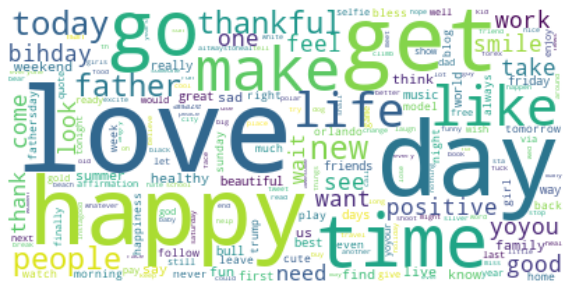

In [41]:
words = []
for tweet in data['tweet_lemmatized']: 
    words.extend(tweet)

show_word_cloud(words)

#### Задание 5.
Теперь отобразим облако слов для отзывов, не содержащих токсичных комментариев (combine_df['label'] == 0).


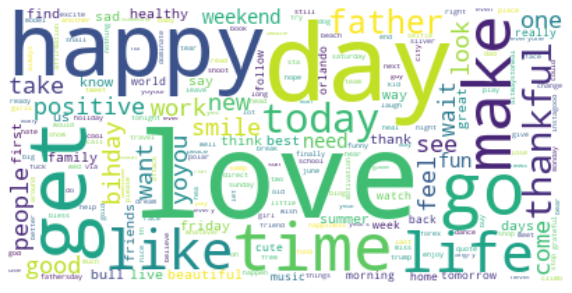

In [42]:
words = []
for tweet in data['tweet_lemmatized'][data['label'] == 0]: 
    words.extend(tweet)

show_word_cloud(words)

#### Задание 6.
Теперь отобразим облако слов для отзывов, содержащих токсичные комментарии (combine_df['label'] == 1). 


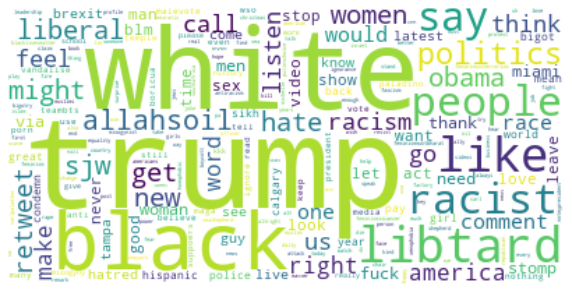

In [43]:
words = []
for tweet in data['tweet_lemmatized'][data['label'] == 1]: 
    words.extend(tweet)

show_word_cloud(words)